# Evaluate Grid Search
In this notebook, I want to analyse the results from a conducted grid search over GCN hyper-parameters.
This should show me which ones perform best.

In [1]:
import pickle, os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

## Parameters

In [2]:
training_dir = '../data/GCN/training/gridsearch_CPDB_new/'

## Box Plot of Best Cross-Validation Runs

In [3]:
def write_hyper_param_dict(params, file_name):
    with open(file_name, 'wb') as f:
        pickle.dump(params, f)

def load_hyper_param_dict(file_name):
    with open(file_name, 'rb') as f:
        params = pickle.load(f)
    return params

def write_performances(performance, file_name):
    write_hyper_param_dict(performance, file_name)

def load_performances(file_name):
    return load_hyper_param_dict(file_name)

def get_performances(training_dir):
    results = []
    for param_dir in os.listdir(training_dir):
        if param_dir.startswith('params'): # it's really a directory from us
            param_file = os.path.join(training_dir, param_dir, 'params.txt')
            performance_file = os.path.join(training_dir, param_dir, 'performance.txt')
            if os.path.exists(param_file) and os.path.exists(performance_file):
                parameters = load_hyper_param_dict(param_file)
                performance = load_performances(performance_file)
                results.append((performance, parameters))
    return results

In [4]:
performances = get_performances(training_dir=training_dir)
len(performances)

288

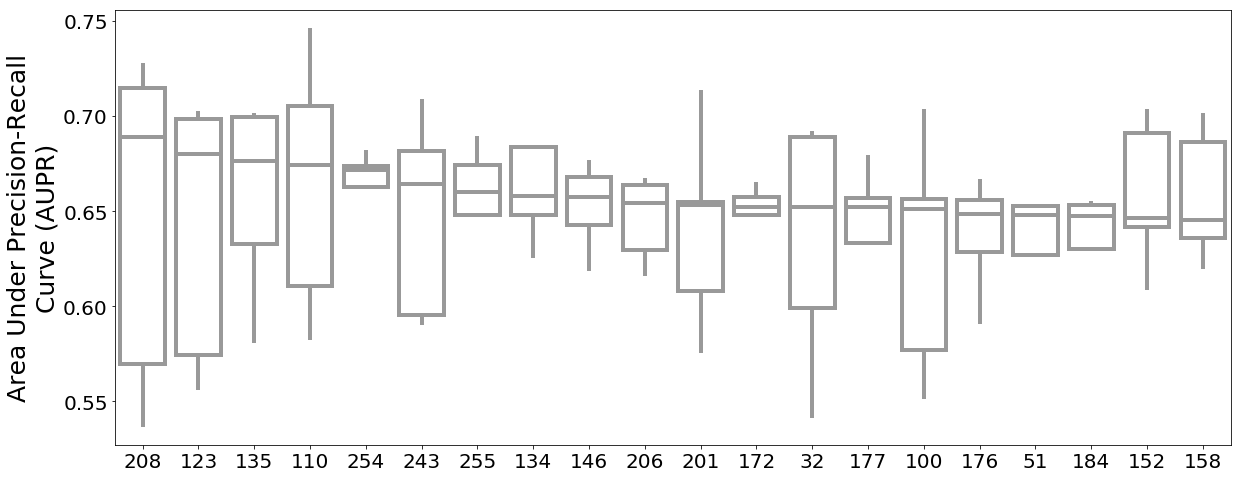

In [5]:
num_to_print = 20
aupr_sorted = sorted(performances, key=lambda x: np.median(x[0]['aupr']),
                     reverse=True)
#aupr_sorted = performances
indices = np.argsort([np.median(p[0]['aupr']) for p in performances])[::-1]
#indices = list(range(1, len(performances)+1))
fig, ax = plt.subplots(figsize=(20, 8))
#fig = plt.figure(figsize=(14,  8))
n_best = aupr_sorted[:num_to_print]
#indices = list(range(1, 21))
c = 'black'
x = seaborn.boxplot(data=[i[0]['aupr'] for i in aupr_sorted[:num_to_print]],
                    linewidth=4, showcaps=False, showfliers=False, color='white'
                   )
#x = seaborn.swarmplot(data=aupr_only[:num_to_print])
x.set_xticklabels(indices[:num_to_print])
ax.set_ylabel('Area Under Precision-Recall\nCurve (AUPR)', fontsize=25)
#ax.set_xlabel('Indices of Grid Search Run', fontsize=25)
plt.gca().tick_params(axis='both', labelsize=20)
plt.gca().tick_params(axis='x', labelsize=20)#, rotation=90)
#fig.savefig(os.path.join(training_dir, 'boxplot_best_{}_aupr.pdf'.format(num_to_print)))#, dpi=300)

In [6]:
performances[254]

({'aupr': [0.6627634, 0.67384154, 0.615973, 0.681171, 0.6715866],
  'loss': [1.1807135, 1.1451797, 1.1522388, 1.1296351, 1.1597979],
  'accuracy': [0.57425743, 0.6476427, 0.62189054, 0.68159205, 0.5895522],
  'num_predicted': [8527, 7534, 7608, 6940, 7900]},
 {'hidden_dims': [300, 100],
  'loss_mul': 45,
  'weight_decay': 0.005,
  'dropout': 0.75,
  'learningrate': 0.001,
  'support': 1,
  'epochs': 2000})

288


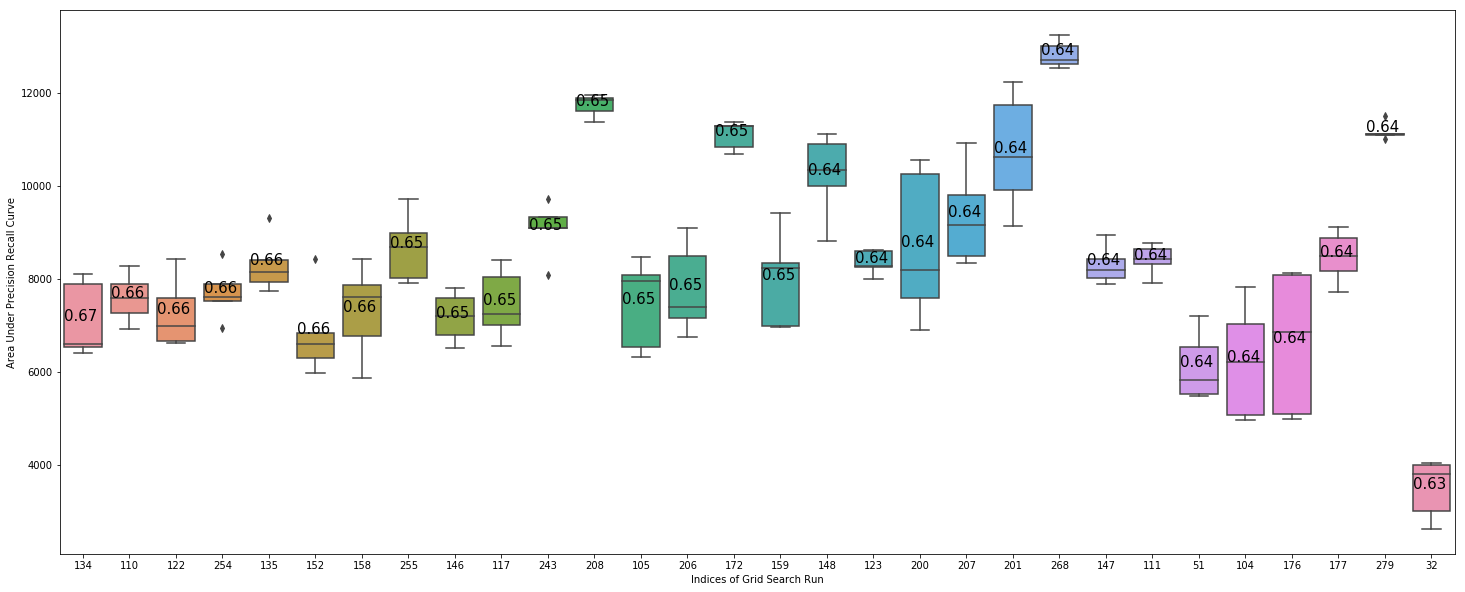

In [7]:
def boxplot_performances(perf, num_to_plot, sort_func, reverse=True, value_to_show='aupr'):
    perf_sorted = sorted(perf, key=sort_func, reverse=reverse)
    indices = np.argsort([sort_func(p) for p in perf])
    if reverse:
        indices = indices[::-1]
    to_show = [p[0][value_to_show] for p in perf_sorted]
    
    # plot boxplot
    fig, ax = plt.subplots(figsize=(25, 10))
    x = seaborn.boxplot(data=to_show[:num_to_plot])
    x.set_xticklabels(indices)
    # plot upper labels
    x_pos = np.arange(num_to_plot)
    y_pos = [np.mean(x[0][value_to_show]) for x in perf_sorted]
    labels = ['{0:.2f}'.format(np.mean(x[0]['aupr'])) for x in perf_sorted]
    
    for tick, label in zip(range(num_to_plot), ax.get_xticklabels()):
        ax.text(x_pos[tick]-.4, y_pos[tick], labels[tick], fontsize=15)

    ax.set_ylabel('Area Under Precision Recall Curve')
    ax.set_xlabel('Indices of Grid Search Run')
    fig.savefig(os.path.join(training_dir, 'boxplot_best_{}_aupr.png'.format(num_to_print)), dpi=300)

#pp38 = [p for p in performances if np.mean(p[0]['num_predicted']) >= 1]
desired_perfs = [p for p in performances if p[1]['support'] == 1]
print (len(desired_perfs))
boxplot_performances(desired_perfs,
                     30,
                     lambda x: np.mean(np.array(x[0]['aupr'])),
                     reverse=True,
                     value_to_show='num_predicted') # accuracy, aupr, num_predicted, loss